In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [4]:
models = {
    "alibaba/qwen2.5-32b-instruct": {
        "label": "Qwen2.5-32B", 
        "color": colors[0],
    },
    "openrouter-deepseek/deepseek-r1-distill-qwen-32b": {
        "label": "DeepsSeek-R1-Distill-Qwen-32B", 
        "color": colors[1],
    },  
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepsSeek-R1", 
        "color": colors[2],
    },  
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B", 
        "color": colors[3],
    },
}


metrics = {
    "average_forgetting_rate": {
        "label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": "Average Solution Count",
    },
    "overall_average_verification_rate": {
        "label": "Average Verification Rate",
    },
    "filtered_ajd": {
        "label": "Average Jump Distance",
    },
    "average_success_rate": {
        "label": "Average Success Rate",
    },
    "average_overthinking_rate": {
        "label": "Average Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}
dataset = "game24"

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
pass1 = {}

reasoning_metrics = {}
for model in models:
    
    row = get_row(
        task_vis_results, 
        model_name=model, 
        dataset_name=dataset, 
    )
    for metric in dataset_metrics[dataset]:
        if metric not in reasoning_metrics:
            reasoning_metrics[metric] = {}
            
        reasoning_metrics[metric][model] = row.iloc[0][metric]
    
    


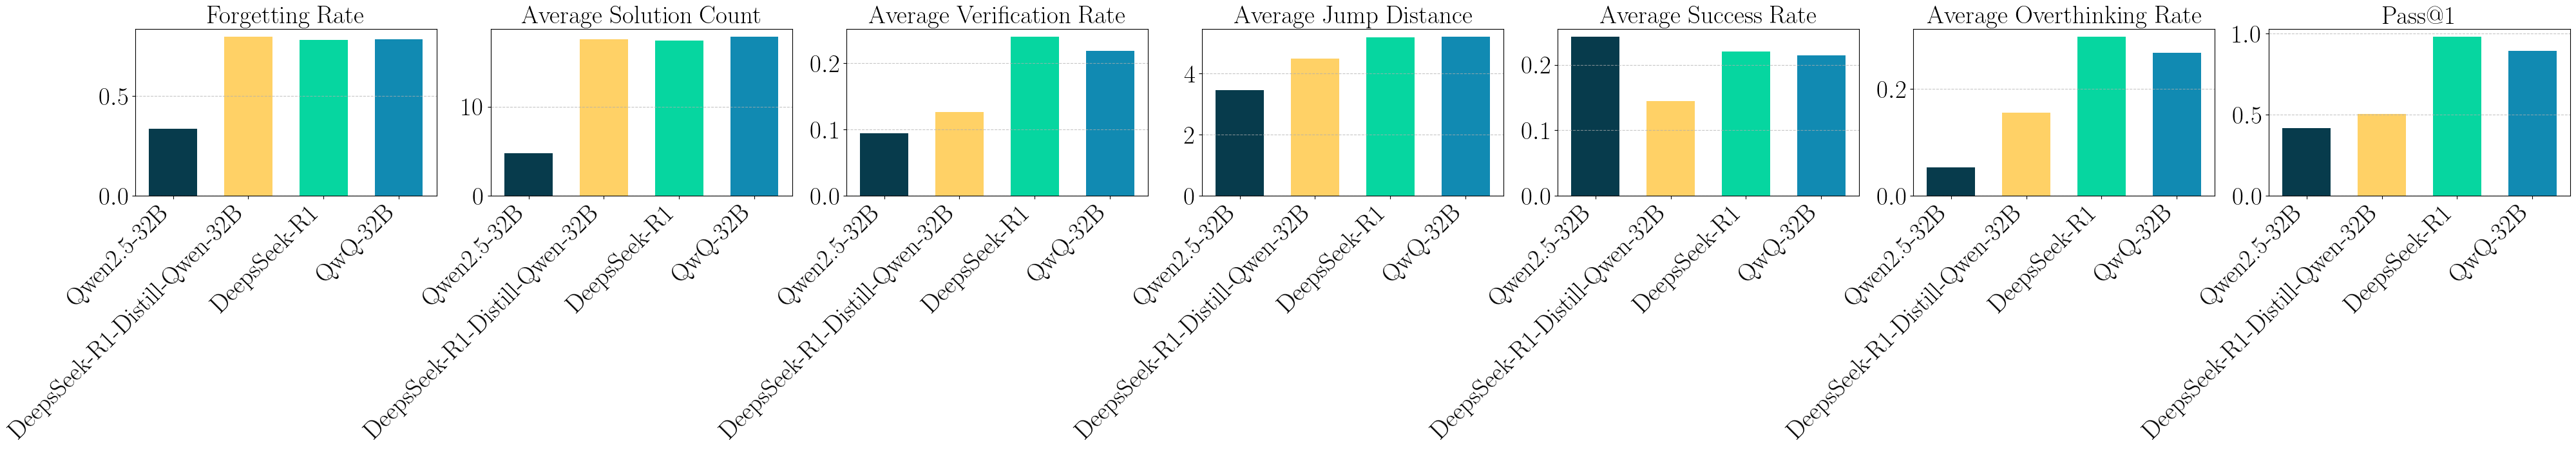

In [18]:
# Get model names
model_names = list(models.keys())

# Number of metrics and models
n_metrics = len(dataset_metrics[dataset])
n_models = len(model_names)
width = 0.8  # Width of each bar

# Create a figure with subplots - one for each metric
fig, axes = plt.subplots(1, n_metrics)
fig.subplots_adjust(left=0.05, bottom=.55, right=0.995, top=.92, wspace=0.18, hspace = 0.3) #margin of the figure
fig.set_size_inches(40, 7) 

# For each metric, create a separate subplot
for m_idx, metric in enumerate(dataset_metrics[dataset]):
    ax = axes[m_idx]
    
    # Collect values for all models for this metric
    values = []
    for model in model_names:
        if model in reasoning_metrics[metric]:
            values.append(reasoning_metrics[metric][model])
        else:
            values.append(0)
    
    # Plot bars for each model
    positions = np.arange(n_models)
    bars = ax.bar(positions, values, width * 0.8, 
                  color=[models[model]["color"] for model in model_names])
    
    # Add value labels on top of bars
    # for bar, value in zip(bars, values):
    #     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
    #             f'{value:.2f}', ha='center', va='bottom', fontsize=22)
    
    # Set title and labels for this subplot
    ax.set_title(metrics[metric]["label"], fontsize=28)
    ax.set_xticks(positions)
    ax.set_xticklabels([models[model]["label"] for model in model_names], rotation=45, ha='right')
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # # Only add y-label to the first subplot
    # if m_idx == 0:
    #     ax.set_ylabel('Values', fontsize=22)

# Add a single legend for the entire figure
handles = [plt.Rectangle((0,0),1,1, color=models[model]["color"]) for model in model_names]
labels = [models[model]["label"] for model in model_names]
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), 
#            ncol=n_models, fontsize=18)

# Adjust layout
plt.savefig(f"{root_dir}/figures/distill_{dataset}.pdf")


In [8]:
model_pairs = list(itertools.combinations(models, 2))
similarities = {"tree": {}, "walk": {}}

for model_pair in model_pairs:
    model1, model2 = sorted(model_pair)
    row = get_row(
        compare_results,
        model1=model1,
        model2=model2,
        dataset=dataset,
    )
    similarities["tree"][(model1, model2)] = row.iloc[0]["tree_similarity"]
    similarities["walk"][(model1, model2)] = row.iloc[0]["walk_similarity"]

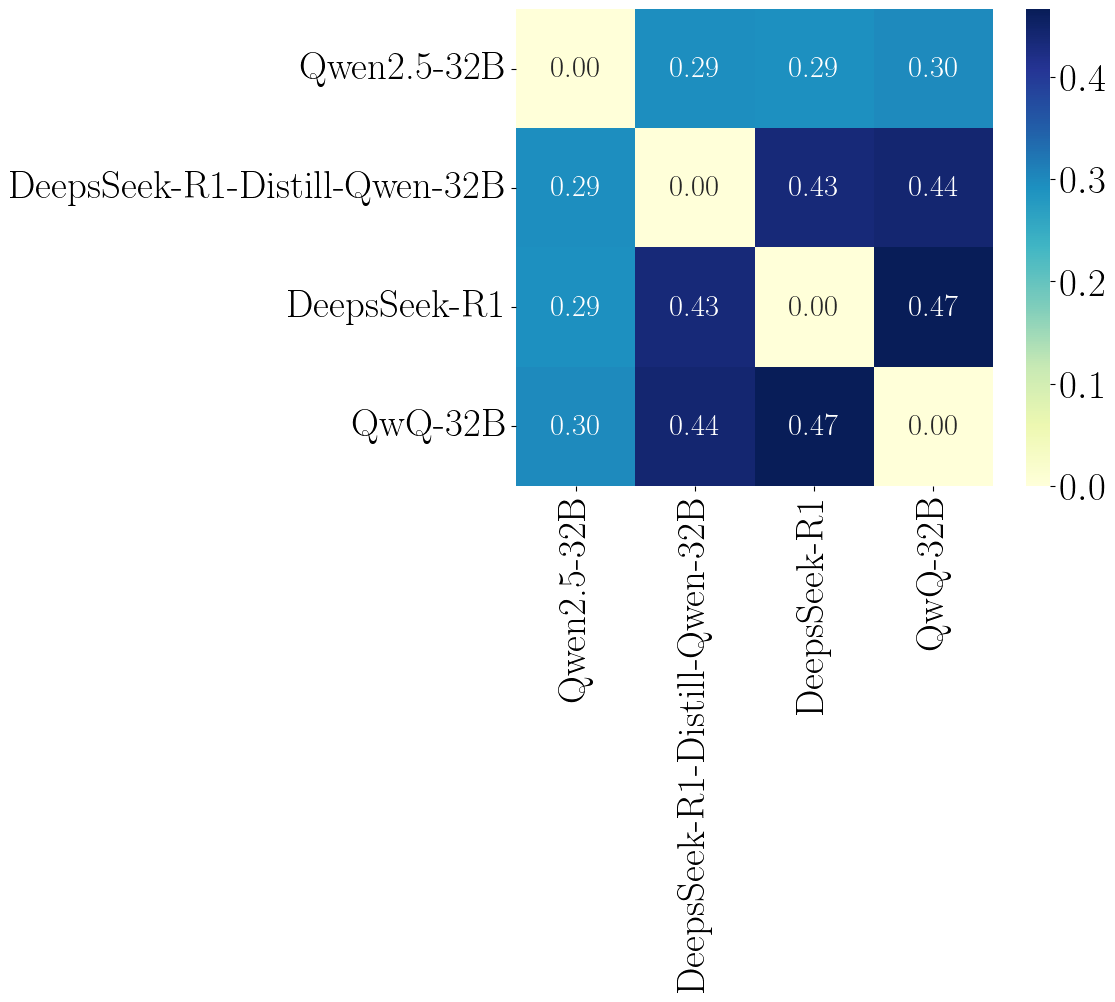

In [10]:
mode = "tree"

distances = similarities[mode]
# Create a heatmap to visualize distances between model pairs
model_names = list(models.keys())
n_models = len(model_names)

# Create a distance matrix
distance_matrix = np.zeros((n_models, n_models))

# Fill the distance matrix
for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i == j:
            # Distance to self is 0
            distance_matrix[i, j] = 0
        else:
            # Get the sorted pair to match our distances dictionary keys
            sorted_pair = tuple(sorted([model1, model2]))
            if sorted_pair in distances:
                distance_matrix[i, j] = distances[sorted_pair]

# Create figure and axis
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    distance_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=[models[model]["label"] for model in model_names],
    yticklabels=[models[model]["label"] for model in model_names],
    square=True,
    annot_kws={"size": 22},
)

plt.tight_layout()
plt.show()


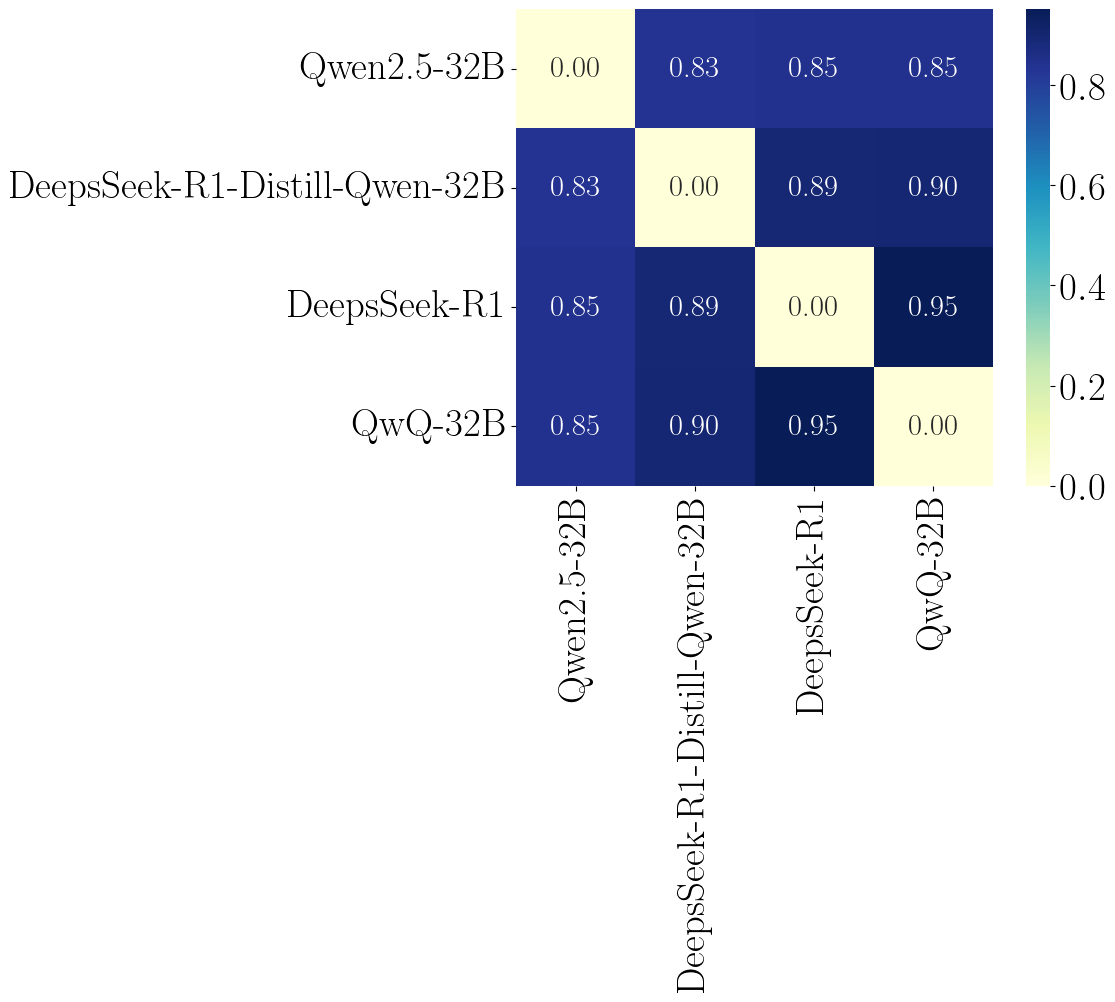

In [11]:
mode = "walk"

distances = similarities[mode]
# Create a heatmap to visualize distances between model pairs
model_names = list(models.keys())
n_models = len(model_names)

# Create a distance matrix
distance_matrix = np.zeros((n_models, n_models))

# Fill the distance matrix
for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i == j:
            # Distance to self is 0
            distance_matrix[i, j] = 0
        else:
            # Get the sorted pair to match our distances dictionary keys
            sorted_pair = tuple(sorted([model1, model2]))
            if sorted_pair in distances:
                distance_matrix[i, j] = distances[sorted_pair]

# Create figure and axis
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(
    distance_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=[models[model]["label"] for model in model_names],
    yticklabels=[models[model]["label"] for model in model_names],
    square=True,
    annot_kws={"size": 22},
)

plt.tight_layout()
plt.show()
